In [1]:
import numpy as np
from msdm.domains import GridWorld
from msdm.core.problemclasses.mdp import TabularPolicy,TabularMarkovDecisionProcess
from msdm.core.assignment import AssignmentMap

C:\Users\user\Miniconda3\envs\research\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\Miniconda3\envs\research\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\user\Miniconda3\envs\research\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [9]:
defaultparams = dict(
    initial_features=('s',),
    absorbing_features=('g',),
    wall_features=('#',),
    default_features=('.',),
    feature_rewards={
        'g': 0,
        'x': -20
    },
    step_cost=-1,
)

gw = GridWorld(
    tile_array=[
        '..#..g',
        '..#...',
        '..#...',
        's.....',
    ],
    **defaultparams
)

policy_iter = PolicyIteration(gw)
output = policy_iter.Iterate()

(25, 5, 25)


(-0.30000000000000004, 6.3, -0.2, 4.2)

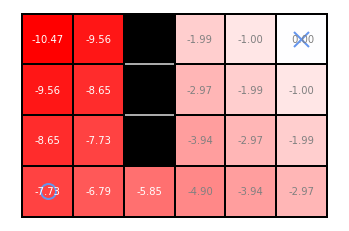

In [4]:
gwp = gw.plot().plot_state_map(output['value'])
gwp.ax.axis('equal')

In [8]:
class PolicyIteration:
    def __init__(self, env, th = 0.1, d = 0.99):
        # pull input parameters
        self.th = th
        self.d = d
        
        # set up environment
        mdp = env
        self.S = mdp.state_list # set of all states from MDP
        self.A = mdp.action_list # set of all actions from MDP
        self.P = mdp.transitionmatrix# state transition function
        # P is sparse: vector representation > huge (think of as function)
        self.R = mdp.rewardmatrix# reward function
        
        # initialize value function and policy
        vi = np.zeros(len(self.S))
        self.V = AssignmentMap([(s,v) for s,v in zip(self.S,vi)])
        self.policy = AssignmentMap([(s,self.A[0]) for s in self.S])
        
    def Iterate(self):
        while True:
            self.policyEvaluation()
            output = self.policyImprovement()
            if output["policy"] != -1:
                return output
        
        
    def policyEvaluation(self):
        # Policy evaluation
        # outputs from MDP are not guaranteed to be hashable
        # use dictionaries
        dif = 100
        S = self.S
        A = self.A
        P = self.P
        R = self.R
        V = self.V
        while dif >= self.th:
            dif = 0
            for s in S:
                v = V[s]
                new_v = 0
                s_i = S.index(s)
                a_i = A.index(self.policy[s])
                for i in range(len(S)):
                    #print(a.keys())
                    #print(self.policy[s])
                    p = P[s_i][a_i][i] # probability
                    n = S[i] # next_state
                    r = R[s_i][a_i][i] # reward
                    new_v += p * (r + self.d * V[n])
                    #print(p,n,r,policy[s],V[n])
                V[s] = new_v
                #print(v, V[s])
                dif = max(dif, abs(v - V[s])) 
                
    def policyImprovement(self):
        # Policy improvement
        policy_stable = True

        S = self.S
        A = self.A
        P = self.P
        R = self.R
        V = self.V
        
        Q = AssignmentMap()
        for s in S:
            old_action = self.policy[s]
            Q[s] = AssignmentMap([(a,0) for a in A])
            for a in A:
                # p = probabilty, n = next state, r = reward
                #init actions
                s_i = S.index(s)
                a_i = A.index(a)
                for i in range(len(S)):
                        #print(a.keys())
                        old_q = Q[s][a]
                        p = P[s_i][a_i][i] # probability
                        n = S[i] # next_state
                        r = R[s_i][a_i][i] # reward
                        Q[s][a] += p * (r + self.d * V[n])
            max_q = -float("inf")
            max_idx = -1

            for k,v in AssignmentMap.items(Q[s]):
                if v > max_q:
                    max_q = v
                    max_idx = k

            opt_action = max_idx
            self.policy[s] = opt_action

            if old_action != opt_action:
                policy_stable = False
            
            #policy[s] = np.eye(len(A))[opt_action]

        if policy_stable:
            return {"policy": self.policy, "value":V}
        else:
            return {"policy": -1, "value":-1}

In [2]:
defaultparams = dict(
    initial_features=('s',),
    absorbing_features=('g',),
    wall_features=('#',),
    default_features=('.',),
    feature_rewards={
        'g': 0,
        'x': -20
    },
    step_cost=-1,
)

gw = GridWorld(
    tile_array=[
        '..#..g',
        '..#...',
        '..#...',
        's.....',
    ],
    **defaultparams
)

In [20]:
# parameters
mdp = gw
S = mdp.state_list # set of all states from MDP
A = mdp.action_list # set of all actions from MDP
P = mdp.transitionmatrix# state transition function
# P is sparse: vector representation > huge (think of as function)
R = mdp.rewardmatrix# reward function
th = 0.01 # threshold, th > 0 
d = 0.99 #discount factor

In [21]:
# initialization
vi = np.zeros(len(S))
V = AssignmentMap([(s,v) for s,v in zip(S,vi)])
policy = AssignmentMap([(s,0) for s in S])

In [22]:
# Policy evaluation
# outputs from MDP are not guaranteed to be hashable
# use dictionaries
dif = 100
while dif >= th:
    dif = 0
    for s in S:
        v = V[s]
        new_v = 0
        s_i = S.index(s)
        for i in range(len(S)):
            #print(a.keys())
            p = P[s_i][policy[s]][i] # probability
            n = S[i] # next_state
            r = R[s_i][policy[s]][i] # reward
            new_v += p * (r + d * V[n])
            #print(p,n,r,policy[s],V[n])
        V[s] = new_v
        print(v, V[s])
        dif = max(dif, abs(v - V[s]))    

0.0 0.0
0.0 -1.0
0.0 -1.0
0.0 -1.0
0.0 -1.0
0.0 -1.99
0.0 -1.99
0.0 -1.99
0.0 -1.99
0.0 -2.9701
0.0 -2.9701
0.0 -2.9701
0.0 -2.9701
0.0 -3.9403989999999998
0.0 -1.0
0.0 -1.0
0.0 -1.0
0.0 -4.90099501
0.0 -1.99
0.0 -1.99
0.0 -1.99
0.0 -5.8519850599
0.0 -2.9701
0.0 -2.9701
0.0 0.0
0.0 0.0
-1.0 -1.99
-1.0 -1.99
-1.0 -1.99
-1.0 -1.99
-1.99 -2.9701
-1.99 -2.9701
-1.99 -2.9701
-1.99 -2.9701
-2.9701 -3.9403989999999998
-2.9701 -3.9403989999999998
-2.9701 -3.9403989999999998
-2.9701 -3.9403989999999998
-3.9403989999999998 -4.90099501
-1.0 -1.99
-1.0 -1.99
-1.0 -1.99
-4.90099501 -5.8519850599
-1.99 -2.9701
-1.99 -2.9701
-1.99 -2.9701
-5.8519850599 -6.793465209301
-2.9701 -3.9403989999999998
-2.9701 -3.9403989999999998
0.0 0.0
0.0 0.0
-1.99 -2.9701
-1.99 -2.9701
-1.99 -2.9701
-1.99 -2.9701
-2.9701 -3.9403989999999998
-2.9701 -3.9403989999999998
-2.9701 -3.9403989999999998
-2.9701 -3.9403989999999998
-3.9403989999999998 -4.90099501
-3.9403989999999998 -4.90099501
-3.9403989999999998 -4.90099501
-3

-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-13.12541872310217 -13.994164535871148
-13.12541872310217 -13.994164535871148
-13.12541872310217 -13.994164535871148
-13.12541872310217 -13.994164535871148
-13.994164535871148 -14.854222890512437
-11.361512828387072 -12.247897700103202
-11.361512828387072 -12.247897700103202
-11.361512828387072 -12.247897700103202
-14.854222890512437 -15.705680661607312
-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-15.705680661607312 -16.54862385499124
-13.12541872310217 -13.994164535871148
-13.12541872310217 -13.994164535871148
0.0 0.0
0.0 0.0
-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-12.247897700103202 -13.12541872310217
-13.12541872310217 -13.994164535871148
-13.12541872310217 -13.994164535871148
-13.

-22.21786406008532 -22.995685419484467
-22.21786406008532 -22.995685419484467
-22.21786406008532 -22.995685419484467
-22.995685419484467 -23.76572856528962
-20.638571635634445 -21.4321859192781
-20.638571635634445 -21.4321859192781
-20.638571635634445 -21.4321859192781
-23.76572856528962 -24.528071279636723
-21.4321859192781 -22.21786406008532
-21.4321859192781 -22.21786406008532
-21.4321859192781 -22.21786406008532
-24.528071279636723 -25.282790566840355
-22.21786406008532 -22.995685419484467
-22.21786406008532 -22.995685419484467
0.0 0.0
0.0 0.0
-21.4321859192781 -22.21786406008532
-21.4321859192781 -22.21786406008532
-21.4321859192781 -22.21786406008532
-21.4321859192781 -22.21786406008532
-22.21786406008532 -22.995685419484467
-22.21786406008532 -22.995685419484467
-22.21786406008532 -22.995685419484467
-22.21786406008532 -22.995685419484467
-22.995685419484467 -23.76572856528962
-22.995685419484467 -23.76572856528962
-22.995685419484467 -23.76572856528962
-22.995685419484467 -23.7

-29.655230500043047 -30.358678195042614
-29.655230500043047 -30.358678195042614
-29.655230500043047 -30.358678195042614
-29.655230500043047 -30.358678195042614
-30.358678195042614 -31.05509141309219
-28.22694674017248 -28.944677272770754
-28.22694674017248 -28.944677272770754
-28.22694674017248 -28.944677272770754
-31.05509141309219 -31.744540498961268
-28.944677272770754 -29.655230500043047
-28.944677272770754 -29.655230500043047
-28.944677272770754 -29.655230500043047
-31.744540498961268 -32.42709509397166
-29.655230500043047 -30.358678195042614
-29.655230500043047 -30.358678195042614
0.0 0.0
0.0 0.0
-28.944677272770754 -29.655230500043047
-28.944677272770754 -29.655230500043047
-28.944677272770754 -29.655230500043047
-28.944677272770754 -29.655230500043047
-29.655230500043047 -30.358678195042614
-29.655230500043047 -30.358678195042614
-29.655230500043047 -30.358678195042614
-29.655230500043047 -30.358678195042614
-30.358678195042614 -31.05509141309219
-30.358678195042614 -31.0550914

-37.647460510879974 -38.27098590577118
-40.10439935338387 -40.70335535985003
-38.27098590577118 -38.888276046713464
-38.27098590577118 -38.888276046713464
0.0 0.0
0.0 0.0
-37.647460510879974 -38.27098590577118
-37.647460510879974 -38.27098590577118
-37.647460510879974 -38.27098590577118
-37.647460510879974 -38.27098590577118
-38.27098590577118 -38.888276046713464
-38.27098590577118 -38.888276046713464
-38.27098590577118 -38.888276046713464
-38.27098590577118 -38.888276046713464
-38.888276046713464 -39.49939328624633
-38.888276046713464 -39.49939328624633
-38.888276046713464 -39.49939328624633
-38.888276046713464 -39.49939328624633
-39.49939328624633 -40.10439935338387
-37.647460510879974 -38.27098590577118
-37.647460510879974 -38.27098590577118
-37.647460510879974 -38.27098590577118
-40.10439935338387 -40.70335535985003
-38.27098590577118 -38.888276046713464
-38.27098590577118 -38.888276046713464
-38.27098590577118 -38.888276046713464
-40.70335535985003 -41.29632180625153
-38.888276046

-46.37317747928146 -46.90944570448865
-44.73165228376146 -45.284335760923845
-44.73165228376146 -45.284335760923845
-44.73165228376146 -45.284335760923845
-46.90944570448865 -47.44035124744376
-45.284335760923845 -45.831492403314606
-45.284335760923845 -45.831492403314606
0.0 0.0
0.0 0.0
-44.73165228376146 -45.284335760923845
-44.73165228376146 -45.284335760923845
-44.73165228376146 -45.284335760923845
-44.73165228376146 -45.284335760923845
-45.284335760923845 -45.831492403314606
-45.284335760923845 -45.831492403314606
-45.284335760923845 -45.831492403314606
-45.284335760923845 -45.831492403314606
-45.831492403314606 -46.37317747928146
-45.831492403314606 -46.37317747928146
-45.831492403314606 -46.37317747928146
-45.831492403314606 -46.37317747928146
-46.37317747928146 -46.90944570448865
-44.73165228376146 -45.284335760923845
-44.73165228376146 -45.284335760923845
-44.73165228376146 -45.284335760923845
-46.90944570448865 -47.44035124744376
-45.284335760923845 -45.831492403314606
-45.28

-51.500862972583676 -51.98585434285784
-51.500862972583676 -51.98585434285784
-53.41192248302062 -53.87780325819041
-51.98585434285784 -52.465995799429265
-51.98585434285784 -52.465995799429265
0.0 0.0
0.0 0.0
-51.500862972583676 -51.98585434285784
-51.500862972583676 -51.98585434285784
-51.500862972583676 -51.98585434285784
-51.500862972583676 -51.98585434285784
-51.98585434285784 -52.465995799429265
-51.98585434285784 -52.465995799429265
-51.98585434285784 -52.465995799429265
-51.98585434285784 -52.465995799429265
-52.465995799429265 -52.94133584143497
-52.465995799429265 -52.94133584143497
-52.465995799429265 -52.94133584143497
-52.465995799429265 -52.94133584143497
-52.94133584143497 -53.41192248302062
-51.500862972583676 -51.98585434285784
-51.500862972583676 -51.98585434285784
-51.500862972583676 -51.98585434285784
-53.41192248302062 -53.87780325819041
-51.98585434285784 -52.465995799429265
-51.98585434285784 -52.465995799429265
-51.98585434285784 -52.465995799429265
-53.87780325

-56.576867320818785 -57.011098647610595
-56.576867320818785 -57.011098647610595
-57.011098647610595 -57.440987661134486
-55.695201837382704 -56.13824981900888
-55.695201837382704 -56.13824981900888
-55.695201837382704 -56.13824981900888
-57.440987661134486 -57.86657778452314
-56.13824981900888 -56.576867320818785
-56.13824981900888 -56.576867320818785
-56.13824981900888 -56.576867320818785
-57.86657778452314 -58.28791200667791
-56.576867320818785 -57.011098647610595
-56.576867320818785 -57.011098647610595
0.0 0.0
0.0 0.0
-56.13824981900888 -56.576867320818785
-56.13824981900888 -56.576867320818785
-56.13824981900888 -56.576867320818785
-56.13824981900888 -56.576867320818785
-56.576867320818785 -57.011098647610595
-56.576867320818785 -57.011098647610595
-56.576867320818785 -57.011098647610595
-56.576867320818785 -57.011098647610595
-57.011098647610595 -57.440987661134486
-57.011098647610595 -57.440987661134486
-57.011098647610595 -57.440987661134486
-57.011098647610595 -57.4409876611344

-60.72889716421946 -61.12160819257726
-60.72889716421946 -61.12160819257726
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-61.51039211065149 -61.89528818954497
-61.51039211065149 -61.89528818954497
-61.51039211065149 -61.89528818954497
-61.51039211065149 -61.89528818954497
-61.89528818954497 -62.27633530764952
-60.72889716421946 -61.12160819257726
-60.72889716421946 -61.12160819257726
-60.72889716421946 -61.12160819257726
-62.27633530764952 -62.653571954573025
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-62.653571954573025 -63.027036235027296
-61.51039211065149 -61.89528818954497
-61.51039211065149 -61.89528818954497
0.0 0.0
0.0 0.0
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-61.12160819257726 -61.51039211065149
-61.51039211065149 -61.89528818

-65.19068855075575 -65.5387816652482
0.0 0.0
0.0 0.0
-64.83907934419773 -65.19068855075575
-64.83907934419773 -65.19068855075575
-64.83907934419773 -65.19068855075575
-64.83907934419773 -65.19068855075575
-65.19068855075575 -65.5387816652482
-65.19068855075575 -65.5387816652482
-65.19068855075575 -65.5387816652482
-65.19068855075575 -65.5387816652482
-65.5387816652482 -65.88339384859572
-65.5387816652482 -65.88339384859572
-65.5387816652482 -65.88339384859572
-65.5387816652482 -65.88339384859572
-65.88339384859572 -66.22455991010976
-64.83907934419773 -65.19068855075575
-64.83907934419773 -65.19068855075575
-64.83907934419773 -65.19068855075575
-66.22455991010976 -66.56231431100866
-65.19068855075575 -65.5387816652482
-65.19068855075575 -65.5387816652482
-65.19068855075575 -65.5387816652482
-66.56231431100866 -66.89669116789858
-65.5387816652482 -65.88339384859572
-65.5387816652482 -65.88339384859572
0.0 0.0
0.0 0.0
-65.19068855075575 -65.5387816652482
-65.19068855075575 -65.5387816652

-68.8338918550857 -69.14555293653484
-70.06196086876682 -70.36134126007914
-69.14555293653484 -69.4540974071695
-69.14555293653484 -69.4540974071695
-69.14555293653484 -69.4540974071695
-70.36134126007914 -70.65772784747836
-69.4540974071695 -69.7595564330978
-69.4540974071695 -69.7595564330978
0.0 0.0
0.0 0.0
-69.14555293653484 -69.4540974071695
-69.14555293653484 -69.4540974071695
-69.14555293653484 -69.4540974071695
-69.14555293653484 -69.4540974071695
-69.4540974071695 -69.7595564330978
-69.4540974071695 -69.7595564330978
-69.4540974071695 -69.7595564330978
-69.4540974071695 -69.7595564330978
-69.7595564330978 -70.06196086876682
-69.7595564330978 -70.06196086876682
-69.7595564330978 -70.06196086876682
-69.7595564330978 -70.06196086876682
-70.06196086876682 -70.36134126007914
-69.14555293653484 -69.4540974071695
-69.14555293653484 -69.4540974071695
-69.14555293653484 -69.4540974071695
-70.36134126007914 -70.65772784747836
-69.4540974071695 -69.7595564330978
-69.4540974071695 -69.759

-72.92457404880055 -73.19532830831254
-72.92457404880055 -73.19532830831254
-72.92457404880055 -73.19532830831254
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522941
-73.46337502522941 -73.72874127497711
-73.46337502522941 -73.72874127497711
-73.46337502522941 -73.72874127497711
-73.46337502522941 -73.72874127497711
-73.72874127497711 -73.99145386222735
-72.92457404880055 -73.19532830831254
-72.92457404880055 -73.19532830831254
-72.92457404880055 -73.19532830831254
-73.99145386222735 -74.25153932360507
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522941
-74.25153932360507 -74.50902393036903
-73.46337502522941 -73.72874127497711
-73.46337502522941 -73.72874127497711
0.0 0.0
0.0 0.0
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522941
-73.19532830831254 -73.46337502522

-76.0007520415865 -76.24074452117063
-76.24074452117063 -76.47833707595892
-75.51347009650699 -75.75833539554192
-75.51347009650699 -75.75833539554192
-75.51347009650699 -75.75833539554192
-76.47833707595892 -76.71355370519933
-75.75833539554192 -76.0007520415865
-75.75833539554192 -76.0007520415865
-75.75833539554192 -76.0007520415865
-76.71355370519933 -76.94641816814733
-76.0007520415865 -76.24074452117063
-76.0007520415865 -76.24074452117063
0.0 0.0
0.0 0.0
-75.75833539554192 -76.0007520415865
-75.75833539554192 -76.0007520415865
-75.75833539554192 -76.0007520415865
-75.75833539554192 -76.0007520415865
-76.0007520415865 -76.24074452117063
-76.0007520415865 -76.24074452117063
-76.0007520415865 -76.24074452117063
-76.0007520415865 -76.24074452117063
-76.24074452117063 -76.47833707595892
-76.24074452117063 -76.47833707595892
-76.24074452117063 -76.47833707595892
-76.24074452117063 -76.47833707595892
-76.47833707595892 -76.71355370519933
-75.75833539554192 -76.0007520415865
-75.7583353

-78.51255522939196 -78.72742967709804
-78.72742967709804 -78.94015538032707
-78.72742967709804 -78.94015538032707
-78.72742967709804 -78.94015538032707
-78.72742967709804 -78.94015538032707
-78.94015538032707 -79.1507538265238
-78.29551033271916 -78.51255522939196
-78.29551033271916 -78.51255522939196
-78.29551033271916 -78.51255522939196
-79.1507538265238 -79.35924628825856
-78.51255522939196 -78.72742967709804
-78.51255522939196 -78.72742967709804
-78.51255522939196 -78.72742967709804
-79.35924628825856 -79.56565382537597
-78.72742967709804 -78.94015538032707
-78.72742967709804 -78.94015538032707
0.0 0.0
0.0 0.0
-78.51255522939196 -78.72742967709804
-78.51255522939196 -78.72742967709804
-78.51255522939196 -78.72742967709804
-78.51255522939196 -78.72742967709804
-78.72742967709804 -78.94015538032707
-78.72742967709804 -78.94015538032707
-78.72742967709804 -78.94015538032707
-78.72742967709804 -78.94015538032707
-78.94015538032707 -79.1507538265238
-78.94015538032707 -79.1507538265238


-80.95385402349717 -81.1443154832622
-80.95385402349717 -81.1443154832622
-80.95385402349717 -81.1443154832622
-81.1443154832622 -81.33287232842959
-80.56714011172042 -80.76146871060321
-80.56714011172042 -80.76146871060321
-80.56714011172042 -80.76146871060321
-81.33287232842959 -81.51954360514529
-80.76146871060321 -80.95385402349717
-80.76146871060321 -80.95385402349717
-80.76146871060321 -80.95385402349717
-81.51954360514529 -81.70434816909383
-80.95385402349717 -81.1443154832622
-80.95385402349717 -81.1443154832622
0.0 0.0
0.0 0.0
-80.76146871060321 -80.95385402349717
-80.76146871060321 -80.95385402349717
-80.76146871060321 -80.95385402349717
-80.76146871060321 -80.95385402349717
-80.95385402349717 -81.1443154832622
-80.95385402349717 -81.1443154832622
-80.95385402349717 -81.1443154832622
-80.95385402349717 -81.1443154832622
-81.1443154832622 -81.33287232842959
-81.1443154832622 -81.33287232842959
-81.1443154832622 -81.33287232842959
-81.1443154832622 -81.33287232842959
-81.332872

-82.94725691104126 -83.11778434193086
-82.42526985088233 -82.6010171523735
-82.42526985088233 -82.6010171523735
-82.42526985088233 -82.6010171523735
-83.11778434193086 -83.28660649851155
-82.6010171523735 -82.77500698084977
-82.6010171523735 -82.77500698084977
0.0 0.0
0.0 0.0
-82.42526985088233 -82.6010171523735
-82.42526985088233 -82.6010171523735
-82.42526985088233 -82.6010171523735
-82.42526985088233 -82.6010171523735
-82.6010171523735 -82.77500698084977
-82.6010171523735 -82.77500698084977
-82.6010171523735 -82.77500698084977
-82.6010171523735 -82.77500698084977
-82.77500698084977 -82.94725691104126
-82.77500698084977 -82.94725691104126
-82.77500698084977 -82.94725691104126
-82.77500698084977 -82.94725691104126
-82.94725691104126 -83.11778434193086
-82.42526985088233 -82.6010171523735
-82.42526985088233 -82.6010171523735
-82.42526985088233 -82.6010171523735
-83.11778434193086 -83.28660649851155
-82.6010171523735 -82.77500698084977
-82.6010171523735 -82.77500698084977
-82.6010171523

-84.26467178922094 -84.42202507132873
0.0 0.0
0.0 0.0
-84.10572908002115 -84.26467178922094
-84.10572908002115 -84.26467178922094
-84.10572908002115 -84.26467178922094
-84.10572908002115 -84.26467178922094
-84.26467178922094 -84.42202507132873
-84.26467178922094 -84.42202507132873
-84.26467178922094 -84.42202507132873
-84.26467178922094 -84.42202507132873
-84.42202507132873 -84.57780482061544
-84.42202507132873 -84.57780482061544
-84.42202507132873 -84.57780482061544
-84.42202507132873 -84.57780482061544
-84.57780482061544 -84.73202677240928
-84.10572908002115 -84.26467178922094
-84.10572908002115 -84.26467178922094
-84.10572908002115 -84.26467178922094
-84.73202677240928 -84.88470650468518
-84.26467178922094 -84.42202507132873
-84.26467178922094 -84.42202507132873
-84.26467178922094 -84.42202507132873
-84.88470650468518 -85.03585943963833
-84.42202507132873 -84.57780482061544
-84.42202507132873 -84.57780482061544
0.0 0.0
0.0 0.0
-84.26467178922094 -84.42202507132873
-84.26467178922094

-86.19191869125264 -86.32999950434011
-86.19191869125264 -86.32999950434011
-86.32999950434011 -86.4666995092967
-86.32999950434011 -86.4666995092967
-86.32999950434011 -86.4666995092967
-86.32999950434011 -86.4666995092967
-86.4666995092967 -86.60203251420373
-86.05244312247741 -86.19191869125264
-86.05244312247741 -86.19191869125264
-86.05244312247741 -86.19191869125264
-86.60203251420373 -86.7360121890617
-86.19191869125264 -86.32999950434011
-86.19191869125264 -86.32999950434011
-86.19191869125264 -86.32999950434011
-86.7360121890617 -86.86865206717108
-86.32999950434011 -86.4666995092967
-86.32999950434011 -86.4666995092967
0.0 0.0
0.0 0.0
-86.19191869125264 -86.32999950434011
-86.19191869125264 -86.32999950434011
-86.19191869125264 -86.32999950434011
-86.19191869125264 -86.32999950434011
-86.32999950434011 -86.4666995092967
-86.32999950434011 -86.4666995092967
-86.32999950434011 -86.4666995092967
-86.32999950434011 -86.4666995092967
-86.4666995092967 -86.60203251420373
-86.466699

-88.24300186575715 -88.36057184709958
-87.88311836429509 -88.00428718065213
-87.88311836429509 -88.00428718065213
-87.88311836429509 -88.00428718065213
-88.36057184709958 -88.47696612862858
-88.00428718065213 -88.1242443088456
-88.00428718065213 -88.1242443088456
-88.00428718065213 -88.1242443088456
-88.47696612862858 -88.59219646734229
-88.1242443088456 -88.24300186575715
-88.1242443088456 -88.24300186575715
0.0 0.0
0.0 0.0
-88.00428718065213 -88.1242443088456
-88.00428718065213 -88.1242443088456
-88.00428718065213 -88.1242443088456
-88.00428718065213 -88.1242443088456
-88.1242443088456 -88.24300186575715
-88.1242443088456 -88.24300186575715
-88.1242443088456 -88.24300186575715
-88.1242443088456 -88.24300186575715
-88.24300186575715 -88.36057184709958
-88.24300186575715 -88.36057184709958
-88.24300186575715 -88.36057184709958
-88.24300186575715 -88.36057184709958
-88.36057184709958 -88.47696612862858
-88.00428718065213 -88.1242443088456
-88.00428718065213 -88.1242443088456
-88.0042871

-89.47350981516401 -89.57877471701237
-89.57877471701237 -89.68298696984225
-89.25977942573616 -89.3671816314788
-89.25977942573616 -89.3671816314788
-89.25977942573616 -89.3671816314788
-89.68298696984225 -89.78615710014383
-89.3671816314788 -89.47350981516401
-89.3671816314788 -89.47350981516401
-89.3671816314788 -89.47350981516401
-89.78615710014383 -89.88829552914238
-89.47350981516401 -89.57877471701237
-89.47350981516401 -89.57877471701237
0.0 0.0
0.0 0.0
-89.3671816314788 -89.47350981516401
-89.3671816314788 -89.47350981516401
-89.3671816314788 -89.47350981516401
-89.3671816314788 -89.47350981516401
-89.47350981516401 -89.57877471701237
-89.47350981516401 -89.57877471701237
-89.47350981516401 -89.57877471701237
-89.47350981516401 -89.57877471701237
-89.57877471701237 -89.68298696984225
-89.57877471701237 -89.68298696984225
-89.57877471701237 -89.68298696984225
-89.57877471701237 -89.68298696984225
-89.68298696984225 -89.78615710014383
-89.3671816314788 -89.47350981516401
-89.367

-90.57523065443742 -90.66947834789305
-90.57523065443742 -90.66947834789305
-90.57523065443742 -90.66947834789305
-90.94660417148229 -91.03713812976747
-90.66947834789305 -90.76278356441412
-90.66947834789305 -90.76278356441412
-90.66947834789305 -90.76278356441412
-91.03713812976747 -91.12676674846979
-90.76278356441412 -90.85515572876999
-90.76278356441412 -90.85515572876999
0.0 0.0
0.0 0.0
-90.66947834789305 -90.76278356441412
-90.66947834789305 -90.76278356441412
-90.66947834789305 -90.76278356441412
-90.66947834789305 -90.76278356441412
-90.76278356441412 -90.85515572876999
-90.76278356441412 -90.85515572876999
-90.76278356441412 -90.85515572876999
-90.76278356441412 -90.85515572876999
-90.85515572876999 -90.94660417148229
-90.85515572876999 -90.94660417148229
-90.85515572876999 -90.94660417148229
-90.85515572876999 -90.94660417148229
-90.94660417148229 -91.03713812976747
-90.66947834789305 -90.76278356441412
-90.66947834789305 -90.76278356441412
-90.66947834789305 -90.76278356441

-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-91.89414838378181 -91.975206899944
-91.89414838378181 -91.975206899944
-91.89414838378181 -91.975206899944
-91.89414838378181 -91.975206899944
-91.975206899944 -92.05545483094456
-91.72956676235262 -91.8122710947291
-91.72956676235262 -91.8122710947291
-91.72956676235262 -91.8122710947291
-92.05545483094456 -92.13490028263512
-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-92.13490028263512 -92.21355127980877
-91.89414838378181 -91.975206899944
-91.89414838378181 -91.975206899944
0.0 0.0
0.0 0.0
-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-91.8122710947291 -91.89414838378181
-91.89414838378181 -91.975206899944
-91.89414838378181 -91.975206899944
-91.89414838378181 -91.975206899944
-91.89414838378181 -91.9752068

-92.81509575500847 -92.88694479745838
-92.81509575500847 -92.88694479745838
-92.81509575500847 -92.88694479745838
-92.88694479745838 -92.95807534948379
-92.88694479745838 -92.95807534948379
-92.88694479745838 -92.95807534948379
-92.88694479745838 -92.95807534948379
-92.95807534948379 -93.02849459598896
-92.74252096465503 -92.81509575500847
-92.74252096465503 -92.81509575500847
-92.74252096465503 -92.81509575500847
-93.02849459598896 -93.09820965002906
-92.81509575500847 -92.88694479745838
-92.81509575500847 -92.88694479745838
-92.81509575500847 -92.88694479745838
-93.09820965002906 -93.16722755352878
-92.88694479745838 -92.95807534948379
-92.88694479745838 -92.95807534948379
0.0 0.0
0.0 0.0
-92.81509575500847 -92.88694479745838
-92.81509575500847 -92.88694479745838
-92.81509575500847 -92.88694479745838
-92.81509575500847 -92.88694479745838
-92.88694479745838 -92.95807534948379
-92.88694479745838 -92.95807534948379
-92.88694479745838 -92.95807534948379
-92.88694479745838 -92.95807534948

-93.6314095725105 -93.6950954767854
-93.6314095725105 -93.6950954767854
-93.8823574460294 -93.9435338715691
-93.6950954767854 -93.75814452201755
-93.6950954767854 -93.75814452201755
0.0 0.0
0.0 0.0
-93.6314095725105 -93.6950954767854
-93.6314095725105 -93.6950954767854
-93.6314095725105 -93.6950954767854
-93.6314095725105 -93.6950954767854
-93.6950954767854 -93.75814452201755
-93.6950954767854 -93.75814452201755
-93.6950954767854 -93.75814452201755
-93.6950954767854 -93.75814452201755
-93.75814452201755 -93.82056307679737
-93.75814452201755 -93.82056307679737
-93.75814452201755 -93.82056307679737
-93.75814452201755 -93.82056307679737
-93.82056307679737 -93.8823574460294
-93.6314095725105 -93.6950954767854
-93.6314095725105 -93.6950954767854
-93.6314095725105 -93.6950954767854
-93.8823574460294 -93.9435338715691
-93.6950954767854 -93.75814452201755
-93.6950954767854 -93.75814452201755
-93.6950954767854 -93.75814452201755
-93.9435338715691 -94.0040985328534
-93.75814452201755 -93.8205630

-94.41142801300798 -94.4673137328779
-94.41142801300798 -94.4673137328779
-94.41142801300798 -94.4673137328779
-94.41142801300798 -94.4673137328779
-94.4673137328779 -94.52264059554912
-94.4673137328779 -94.52264059554912
-94.4673137328779 -94.52264059554912
-94.4673137328779 -94.52264059554912
-94.52264059554912 -94.57741418959363
-94.52264059554912 -94.57741418959363
-94.52264059554912 -94.57741418959363
-94.52264059554912 -94.57741418959363
-94.57741418959363 -94.63164004769769
-94.41142801300798 -94.4673137328779
-94.41142801300798 -94.4673137328779
-94.41142801300798 -94.4673137328779
-94.63164004769769 -94.68532364722071
-94.4673137328779 -94.52264059554912
-94.4673137328779 -94.52264059554912
-94.4673137328779 -94.52264059554912
-94.68532364722071 -94.7384704107485
-94.52264059554912 -94.57741418959363
-94.52264059554912 -94.57741418959363
0.0 0.0
0.0 0.0
-94.4673137328779 -94.52264059554912
-94.4673137328779 -94.52264059554912
-94.4673137328779 -94.52264059554912
-94.4673137328

-94.94579567006807 -94.99633771336738
-95.14495148694266 -95.19350197207324
-94.99633771336738 -95.04637433623371
-94.99633771336738 -95.04637433623371
-94.99633771336738 -95.04637433623371
-95.19350197207324 -95.2415669523525
-95.04637433623371 -95.09591059287138
-95.04637433623371 -95.09591059287138
0.0 0.0
0.0 0.0
-94.99633771336738 -95.04637433623371
-94.99633771336738 -95.04637433623371
-94.99633771336738 -95.04637433623371
-94.99633771336738 -95.04637433623371
-95.04637433623371 -95.09591059287138
-95.04637433623371 -95.09591059287138
-95.04637433623371 -95.09591059287138
-95.04637433623371 -95.09591059287138
-95.09591059287138 -95.14495148694266
-95.09591059287138 -95.14495148694266
-95.09591059287138 -95.14495148694266
-95.09591059287138 -95.14495148694266
-95.14495148694266 -95.19350197207324
-94.99633771336738 -95.04637433623371
-94.99633771336738 -95.04637433623371
-94.99633771336738 -95.04637433623371
-95.19350197207324 -95.2415669523525
-95.04637433623371 -95.0959105928713

-95.5648294459523 -95.60918115149278
-95.5648294459523 -95.60918115149278
-95.5648294459523 -95.60918115149278
-95.60918115149278 -95.65308933997785
-95.60918115149278 -95.65308933997785
-95.60918115149278 -95.65308933997785
-95.60918115149278 -95.65308933997785
-95.65308933997785 -95.69655844657808
-95.52002974338616 -95.5648294459523
-95.52002974338616 -95.5648294459523
-95.52002974338616 -95.5648294459523
-95.69655844657808 -95.7395928621123
-95.5648294459523 -95.60918115149278
-95.5648294459523 -95.60918115149278
-95.5648294459523 -95.60918115149278
-95.7395928621123 -95.78219693349118
-95.60918115149278 -95.65308933997785
-95.60918115149278 -95.65308933997785
0.0 0.0
0.0 0.0
-95.5648294459523 -95.60918115149278
-95.5648294459523 -95.60918115149278
-95.5648294459523 -95.60918115149278
-95.5648294459523 -95.60918115149278
-95.60918115149278 -95.65308933997785
-95.60918115149278 -95.65308933997785
-95.60918115149278 -95.65308933997785
-95.60918115149278 -95.65308933997785
-95.6530893

-96.14696415225477 -96.18549451073221
-96.14696415225477 -96.18549451073221
0.0 0.0
0.0 0.0
-96.10804459823714 -96.14696415225477
-96.10804459823714 -96.14696415225477
-96.10804459823714 -96.14696415225477
-96.10804459823714 -96.14696415225477
-96.14696415225477 -96.18549451073221
-96.14696415225477 -96.18549451073221
-96.14696415225477 -96.18549451073221
-96.14696415225477 -96.18549451073221
-96.18549451073221 -96.2236395656249
-96.18549451073221 -96.2236395656249
-96.18549451073221 -96.2236395656249
-96.18549451073221 -96.2236395656249
-96.2236395656249 -96.26140316996864
-96.10804459823714 -96.14696415225477
-96.10804459823714 -96.14696415225477
-96.10804459823714 -96.14696415225477
-96.26140316996864 -96.29878913826896
-96.14696415225477 -96.18549451073221
-96.14696415225477 -96.18549451073221
-96.14696415225477 -96.18549451073221
-96.29878913826896 -96.33580124688626
-96.18549451073221 -96.2236395656249
-96.18549451073221 -96.2236395656249
0.0 0.0
0.0 0.0
-96.14696415225477 -96.18

-96.6188800412349 -96.65269124082255
-96.6188800412349 -96.65269124082255
-96.75210965827887 -96.78458856169608
-96.65269124082255 -96.68616432841432
-96.65269124082255 -96.68616432841432
0.0 0.0
0.0 0.0
-96.6188800412349 -96.65269124082255
-96.6188800412349 -96.65269124082255
-96.6188800412349 -96.65269124082255
-96.6188800412349 -96.65269124082255
-96.65269124082255 -96.68616432841432
-96.65269124082255 -96.68616432841432
-96.65269124082255 -96.68616432841432
-96.65269124082255 -96.68616432841432
-96.68616432841432 -96.71930268513017
-96.68616432841432 -96.71930268513017
-96.68616432841432 -96.71930268513017
-96.68616432841432 -96.71930268513017
-96.71930268513017 -96.75210965827887
-96.6188800412349 -96.65269124082255
-96.6188800412349 -96.65269124082255
-96.6188800412349 -96.65269124082255
-96.75210965827887 -96.78458856169608
-96.65269124082255 -96.68616432841432
-96.65269124082255 -96.68616432841432
-96.65269124082255 -96.68616432841432
-96.78458856169608 -96.81674267607912
-96.6

-97.00302641909315 -97.03299615490221
-97.03299615490221 -97.06266619335318
-96.94217571583833 -96.97275395867995
-96.94217571583833 -96.97275395867995
-96.94217571583833 -96.97275395867995
-97.06266619335318 -97.09203953141964
-96.97275395867995 -97.00302641909315
-96.97275395867995 -97.00302641909315
-96.97275395867995 -97.00302641909315
-97.09203953141964 -97.12111913610545
-97.00302641909315 -97.03299615490221
-97.00302641909315 -97.03299615490221
0.0 0.0
0.0 0.0
-96.97275395867995 -97.00302641909315
-96.97275395867995 -97.00302641909315
-96.97275395867995 -97.00302641909315
-96.97275395867995 -97.00302641909315
-97.00302641909315 -97.03299615490221
-97.00302641909315 -97.03299615490221
-97.00302641909315 -97.03299615490221
-97.00302641909315 -97.03299615490221
-97.03299615490221 -97.06266619335318
-97.03299615490221 -97.06266619335318
-97.03299615490221 -97.06266619335318
-97.03299615490221 -97.06266619335318
-97.06266619335318 -97.09203953141964
-96.97275395867995 -97.00302641909

-97.44820355477081 -97.4737215192231
-97.37009267738173 -97.39639175060792
-97.37009267738173 -97.39639175060792
0.0 0.0
0.0 0.0
-97.34352795695125 -97.37009267738173
-97.34352795695125 -97.37009267738173
-97.34352795695125 -97.37009267738173
-97.34352795695125 -97.37009267738173
-97.37009267738173 -97.39639175060792
-97.37009267738173 -97.39639175060792
-97.37009267738173 -97.39639175060792
-97.37009267738173 -97.39639175060792
-97.39639175060792 -97.42242783310184
-97.39639175060792 -97.42242783310184
-97.39639175060792 -97.42242783310184
-97.39639175060792 -97.42242783310184
-97.42242783310184 -97.44820355477081
-97.34352795695125 -97.37009267738173
-97.34352795695125 -97.37009267738173
-97.34352795695125 -97.37009267738173
-97.44820355477081 -97.4737215192231
-97.37009267738173 -97.39639175060792
-97.37009267738173 -97.39639175060792
-97.37009267738173 -97.39639175060792
-97.4737215192231 -97.49898430403087
-97.39639175060792 -97.42242783310184
-97.39639175060792 -97.42242783310184

-97.59753430150468 -97.62155895848963
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.64534336890473 -97.66888993521569
-97.64534336890473 -97.66888993521569
-97.64534336890473 -97.66888993521569
-97.64534336890473 -97.66888993521569
-97.66888993521569 -97.69220103586353
-97.59753430150468 -97.62155895848963
-97.59753430150468 -97.62155895848963
-97.59753430150468 -97.62155895848963
-97.69220103586353 -97.7152790255049
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.7152790255049 -97.73812623524985
-97.64534336890473 -97.66888993521569
-97.64534336890473 -97.66888993521569
0.0 0.0
0.0 0.0
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.62155895848963 -97.64534336890473
-97.64534336890473 -97.66888993521569
-97.64534336890473 -97.6688899352156

-97.87049075003682 -97.89178584253645
-97.87049075003682 -97.89178584253645
-97.87049075003682 -97.89178584253645
-97.87049075003682 -97.89178584253645
-97.89178584253645 -97.91286798411109
-97.89178584253645 -97.91286798411109
-97.89178584253645 -97.91286798411109
-97.89178584253645 -97.91286798411109
-97.91286798411109 -97.93373930426998
-97.91286798411109 -97.93373930426998
-97.91286798411109 -97.93373930426998
-97.91286798411109 -97.93373930426998
-97.93373930426998 -97.95440191122728
-97.87049075003682 -97.89178584253645
-97.87049075003682 -97.89178584253645
-97.87049075003682 -97.89178584253645
-97.95440191122728 -97.97485789211501
-97.89178584253645 -97.91286798411109
-97.89178584253645 -97.91286798411109
-97.89178584253645 -97.91286798411109
-97.97485789211501 -97.99510931319386
-97.91286798411109 -97.93373930426998
-97.91286798411109 -97.93373930426998
0.0 0.0
0.0 0.0
-97.89178584253645 -97.91286798411109
-97.89178584253645 -97.91286798411109
-97.89178584253645 -97.91286798411

-98.09336890571016 -98.11243521665307
-98.09336890571016 -98.11243521665307
-98.16849777828325 -98.18681280050042
-98.11243521665307 -98.13131086448654
-98.11243521665307 -98.13131086448654
-98.11243521665307 -98.13131086448654
-98.18681280050042 -98.20494467249542
-98.13131086448654 -98.14999775584167
-98.13131086448654 -98.14999775584167
0.0 0.0
0.0 0.0
-98.11243521665307 -98.13131086448654
-98.11243521665307 -98.13131086448654
-98.11243521665307 -98.13131086448654
-98.11243521665307 -98.13131086448654
-98.13131086448654 -98.14999775584167
-98.13131086448654 -98.14999775584167
-98.13131086448654 -98.14999775584167
-98.13131086448654 -98.14999775584167
-98.14999775584167 -98.16849777828325
-98.14999775584167 -98.16849777828325
-98.14999775584167 -98.16849777828325
-98.14999775584167 -98.16849777828325
-98.16849777828325 -98.18681280050042
-98.11243521665307 -98.13131086448654
-98.11243521665307 -98.13131086448654
-98.11243521665307 -98.13131086448654
-98.18681280050042 -98.20494467249

-98.37658413815579 -98.39281829677424
-98.39281829677424 -98.40889011380649
-98.39281829677424 -98.40889011380649
-98.39281829677424 -98.40889011380649
-98.39281829677424 -98.40889011380649
-98.40889011380649 -98.42480121266843
-98.36018599813717 -98.37658413815579
-98.36018599813717 -98.37658413815579
-98.36018599813717 -98.37658413815579
-98.42480121266843 -98.44055320054174
-98.37658413815579 -98.39281829677424
-98.37658413815579 -98.39281829677424
-98.37658413815579 -98.39281829677424
-98.44055320054174 -98.45614766853632
-98.39281829677424 -98.40889011380649
-98.39281829677424 -98.40889011380649
0.0 0.0
0.0 0.0
-98.37658413815579 -98.39281829677424
-98.37658413815579 -98.39281829677424
-98.37658413815579 -98.39281829677424
-98.37658413815579 -98.39281829677424
-98.39281829677424 -98.40889011380649
-98.39281829677424 -98.40889011380649
-98.39281829677424 -98.40889011380649
-98.39281829677424 -98.40889011380649
-98.40889011380649 -98.42480121266843
-98.40889011380649 -98.42480121266

-98.6315526492269 -98.64523712273463
-98.58966426764009 -98.60376762496368
-98.58966426764009 -98.60376762496368
-98.58966426764009 -98.60376762496368
-98.64523712273463 -98.65878475150728
-98.60376762496368 -98.61772994871404
-98.60376762496368 -98.61772994871404
0.0 0.0
0.0 0.0
-98.58966426764009 -98.60376762496368
-98.58966426764009 -98.60376762496368
-98.58966426764009 -98.60376762496368
-98.58966426764009 -98.60376762496368
-98.60376762496368 -98.61772994871404
-98.60376762496368 -98.61772994871404
-98.60376762496368 -98.61772994871404
-98.60376762496368 -98.61772994871404
-98.61772994871404 -98.6315526492269
-98.61772994871404 -98.6315526492269
-98.61772994871404 -98.6315526492269
-98.61772994871404 -98.6315526492269
-98.6315526492269 -98.64523712273463
-98.58966426764009 -98.60376762496368
-98.58966426764009 -98.60376762496368
-98.58966426764009 -98.60376762496368
-98.64523712273463 -98.65878475150728
-98.60376762496368 -98.61772994871404
-98.60376762496368 -98.61772994871404
-9

-98.74989974279549 -98.76240074536753
-98.74989974279549 -98.76240074536753
-98.79915868082938 -98.81116709402109
-98.76240074536753 -98.77477673791385
-98.76240074536753 -98.77477673791385
-98.76240074536753 -98.77477673791385
-98.81116709402109 -98.82305542308087
-98.77477673791385 -98.78702897053472
-98.77477673791385 -98.78702897053472
0.0 0.0
0.0 0.0
-98.76240074536753 -98.77477673791385
-98.76240074536753 -98.77477673791385
-98.76240074536753 -98.77477673791385
-98.76240074536753 -98.77477673791385
-98.77477673791385 -98.78702897053472
-98.77477673791385 -98.78702897053472
-98.77477673791385 -98.78702897053472
-98.77477673791385 -98.78702897053472
-98.78702897053472 -98.79915868082938
-98.78702897053472 -98.79915868082938
-98.78702897053472 -98.79915868082938
-98.78702897053472 -98.79915868082938
-98.79915868082938 -98.81116709402109
-98.76240074536753 -98.77477673791385
-98.76240074536753 -98.77477673791385
-98.76240074536753 -98.77477673791385
-98.81116709402109 -98.82305542308

-98.88073741806615 -98.89193004388548
-98.92484082965203 -98.93559242135551
-98.89193004388548 -98.90301074344663
-98.89193004388548 -98.90301074344663
0.0 0.0
0.0 0.0
-98.88073741806615 -98.89193004388548
-98.88073741806615 -98.89193004388548
-98.88073741806615 -98.89193004388548
-98.88073741806615 -98.89193004388548
-98.89193004388548 -98.90301074344663
-98.89193004388548 -98.90301074344663
-98.89193004388548 -98.90301074344663
-98.89193004388548 -98.90301074344663
-98.90301074344663 -98.91398063601216
-98.90301074344663 -98.91398063601216
-98.90301074344663 -98.91398063601216
-98.90301074344663 -98.91398063601216
-98.91398063601216 -98.92484082965203
-98.88073741806615 -98.89193004388548
-98.88073741806615 -98.89193004388548
-98.88073741806615 -98.89193004388548
-98.92484082965203 -98.93559242135551
-98.89193004388548 -98.90301074344663
-98.89193004388548 -98.90301074344663
-98.89193004388548 -98.90301074344663
-98.93559242135551 -98.94623649714195
-98.90301074344663 -98.91398063601

-99.00790257989588 -99.01782355409692
-99.00790257989588 -99.01782355409692
-99.00790257989588 -99.01782355409692
-99.00790257989588 -99.01782355409692
-99.01782355409692 -99.02764531855595
-99.01782355409692 -99.02764531855595
-99.01782355409692 -99.02764531855595
-99.01782355409692 -99.02764531855595
-99.02764531855595 -99.0373688653704
-99.02764531855595 -99.0373688653704
-99.02764531855595 -99.0373688653704
-99.02764531855595 -99.0373688653704
-99.0373688653704 -99.04699517671669
-99.00790257989588 -99.01782355409692
-99.00790257989588 -99.01782355409692
-99.00790257989588 -99.01782355409692
-99.04699517671669 -99.05652522494952
-99.01782355409692 -99.02764531855595
-99.01782355409692 -99.02764531855595
-99.01782355409692 -99.02764531855595
-99.05652522494952 -99.06595997270003
-99.02764531855595 -99.0373688653704
-99.02764531855595 -99.0373688653704
0.0 0.0


In [ ]:
# Policy improvement
policy_stable = TRUE

for s in S:
    old_action = policy[s]
    for a in range(len(A)):
        # p = probabilty, n = next state, r = reward
        #init actions
        s_i = S.index(s)
        a_i = A.index(a)
        for i in range(len(S)):
                #print(a.keys())
                old_q = Q[a]
                p = P[s_i][a_i][i] # probability
                n = S[i] # next_state
                r = R[s_i][a_i][i] # reward
                Q[a] += p * (r + d * V[n])
    max_q = 0
    max_idx = -1
    
    for k,v in AssignmentMap.items(Q):
        if v > max_q:
            max_q = v
            max_idx = k
    
    opt_action = max_idx
    
    if old_action != opt_action:
        policy_stable = False
    policy[s] = np.eye(len(A))[opt_action]
    
if policy_stable:
    return policy, V
else:
    return -1, -1

In [ ]:
# Taking policy iteration to tranform to value iteration
V = np.zeros(len(S))
Q = np.zeros([len(S),len(A)])

for s in S:
    v = V[s]
    new_v = 0
    old_action = policy[s]
    for a,p_a in enumerate(policy[s]):
        new_q = 0
        for p, n, r, _ in P[s][a]: # p = probability, n = next_state, r = reward
            # new_v += p_a * p * (r + d *V[n])
            new_q += p * (r + d * V[n])
        Q[s][a] = new_q
    opt_action = np.argmax(Q[s])
    
    # analogous to improvement step
    new_q_best = Q[s][opt_action]
    V[s] = new_q_best
    
    # termination condition
    if old_action != opt_action:
        policy_stable = False
    policy[s] = np.eye(len(A))[opt_action]
    
if policy_stable:
    # return policy, V
    